<a href="https://colab.research.google.com/github/peppefdf/Generate_stops/blob/main/Generate_stops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Point density function for cluster:  0


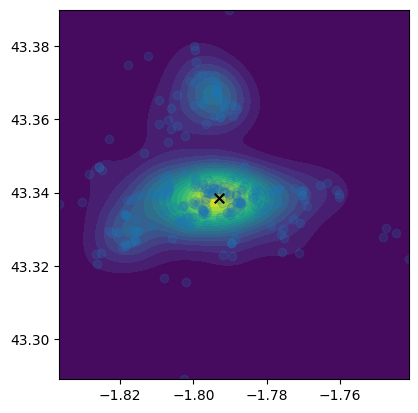

<ipython-input-24-f58a42d1a00e>:37: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
<ipython-input-24-f58a42d1a00e>:41: DeprecationWarning: Please use `minimum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
<ipython-input-24-f58a42d1a00e>:53: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  eroded_background = morphology.binary_erosion(


Local maxima for cluster:  0
(array([  0,  58,  73, 114]), array([ 53, 141,  68,  66]))
Local maxima within 10% of absolute max:
43.33844900983549 -1.7931267753202749
43.366171131313926 -1.7944050923477286

Point density function for cluster:  1


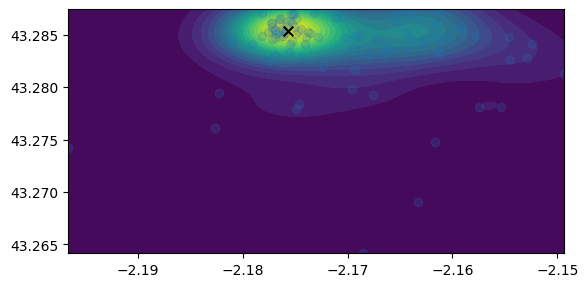

Local maxima for cluster:  1
(array([  0,  32,  64,  90, 136, 136]), array([ 89, 105,   0, 127,  66, 103]))
Local maxima within 10% of absolute max:
43.285379439932385 -2.175703380317751
43.285379439932385 -2.1639667719019453

Point density function for cluster:  2


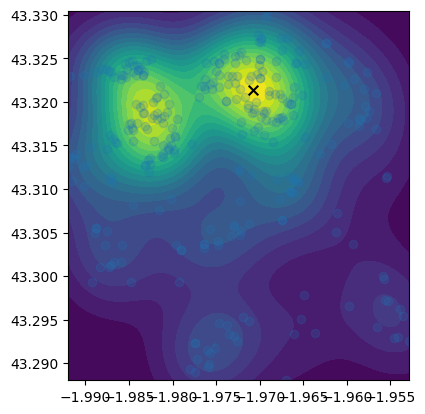

Local maxima for cluster:  2
(array([ 14,  28, 107, 117]), array([ 64, 140,  36,  81]))
Local maxima within 10% of absolute max:
43.292027058574 -1.9751930217107694
43.29601366201433 -1.955227653202376
43.31850949571337 -1.9825486837928092
43.32135706959933 -1.9707270840181026

Point density function for cluster:  3


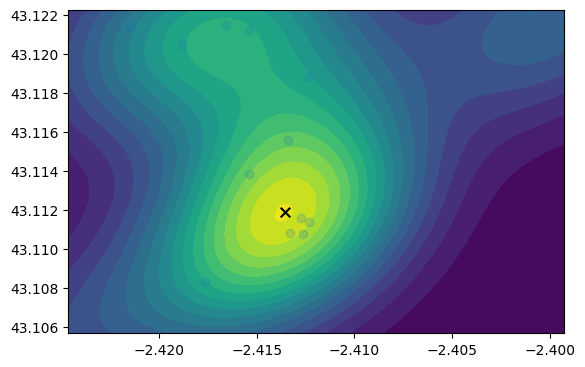

Local maxima for cluster:  3
(array([ 56, 132, 143]), array([ 65,  47, 142]))
Local maxima within 10% of absolute max:
43.111908315777505 -2.413577592300912
43.120350184917335 -2.41664723164408
43.121572034398106 -2.4004463573329144

Point density function for cluster:  4


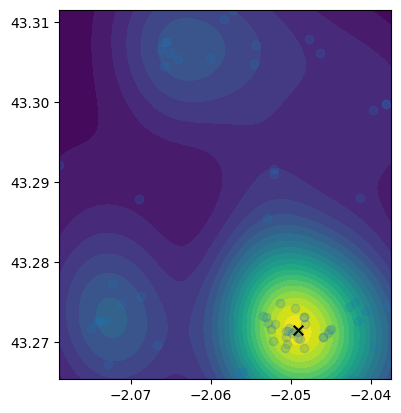

Local maxima for cluster:  4
(array([ 20,  25, 113, 133]), array([107,  23, 135,  57]))
Local maxima within 10% of absolute max:
43.271525633604114 -2.0491384449610415
43.27307618047484 -2.0725392360150754
43.30036580539954 -2.0413381812763634
43.30656799288242 -2.0630674872551094

Point density function for cluster:  5


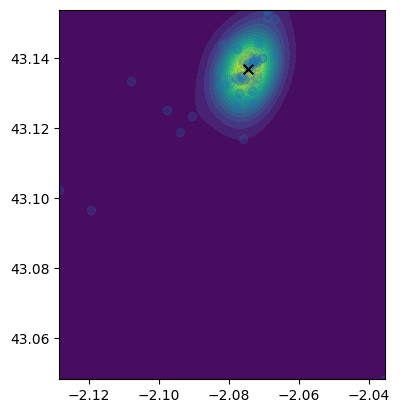

Local maxima for cluster:  5
(array([  0,  70,  75, 120, 125]), array([149,  11,   3,  34,  86]))
Local maxima within 10% of absolute max:
43.13675570258261 -2.074699916145996

Point density function for cluster:  6


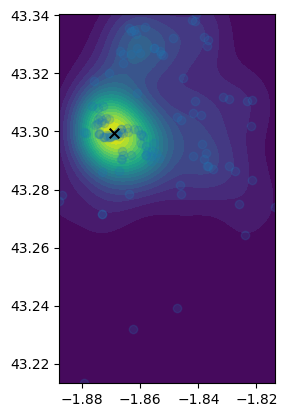

Local maxima for cluster:  6
(array([  0,  23,  29, 101, 135]), array([18, 55, 77, 38, 55]))
Local maxima within 10% of absolute max:
43.29956242816611 -1.8689786642675474
43.32861588284958 -1.8605060036210515

Point density function for cluster:  7


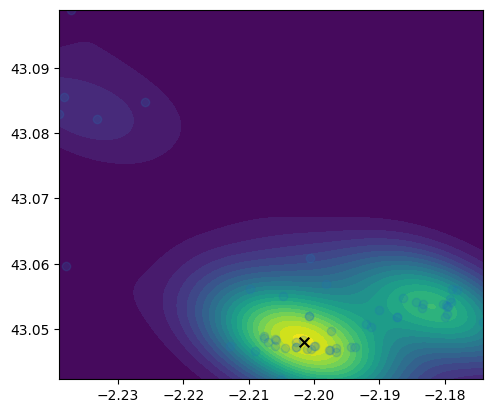

Local maxima for cluster:  7
(array([ 15,  29,  45, 109, 145]), array([ 86, 131,   4,   7,   6]))
Local maxima within 10% of absolute max:
43.0480436702496 -2.201602904265589
43.05335431617096 -2.1820536889478115
43.08370086429302 -2.2359226378234647

Point density function for cluster:  8


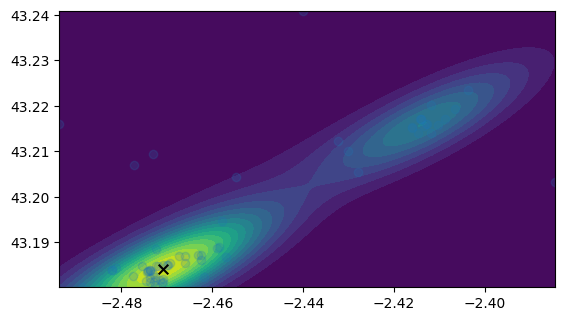

Local maxima for cluster:  8
(array([ 10,  57,  69,  88,  88, 149]), array([ 31, 149,  25,   0, 109,  73]))
Local maxima within 10% of absolute max:
43.18416738743292 -2.4709509974597204
43.215995578550576 -2.4138140251991613

Point density function for cluster:  9


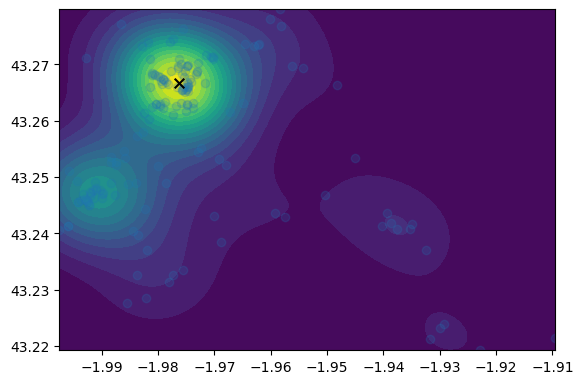

Local maxima for cluster:  9
(array([  8,  55,  69, 117]), array([116, 101,  12,  36]))
Local maxima within 10% of absolute max:
43.24158106891995 -1.9378754576101573
43.24726853312373 -1.9904679026059728
43.266768410393816 -1.9762856702475506

Point density function for cluster:  10


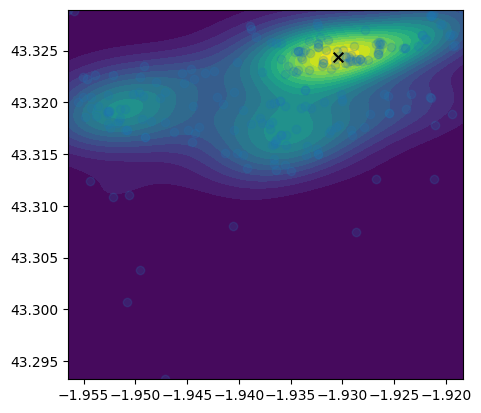

Local maxima for cluster:  10
(array([  0,  38,  62, 101, 109, 130, 148]), array([ 37,  25, 111,  83,  21, 102,   1]))
Local maxima within 10% of absolute max:
43.31745386609577 -1.9352495358122317
43.319371131170314 -1.9511318678324654
43.324403951990995 -1.9303823695479667

Point density function for cluster:  11


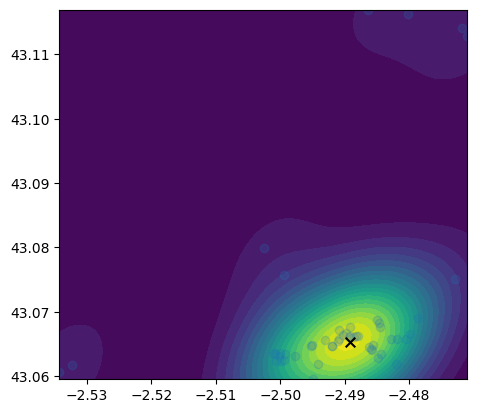

Local maxima for cluster:  11
(array([  4,  15, 141]), array([  2, 106, 144]))
Local maxima within 10% of absolute max:
43.065289943401375 -2.489216776911826

Point density function for cluster:  12


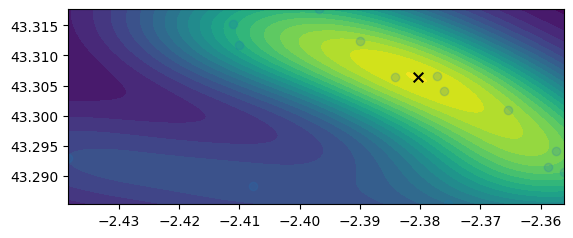

Local maxima for cluster:  12
(array([17, 97]), array([ 52, 105]))
Local maxima within 10% of absolute max:
43.28898809997437 -2.4097319146054303
43.30637555708846 -2.3804478594529286

Point density function for cluster:  13


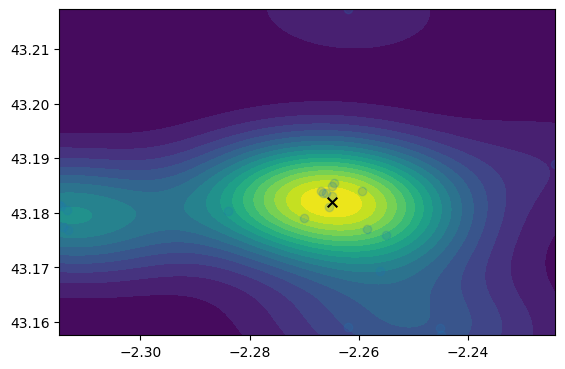

Local maxima for cluster:  13
(array([ 55,  61, 149]), array([ 4, 82, 87]))
Local maxima within 10% of absolute max:
43.17961459780958 -2.312389085760032
43.18201895292331 -2.2648451916716925

Point density function for cluster:  14


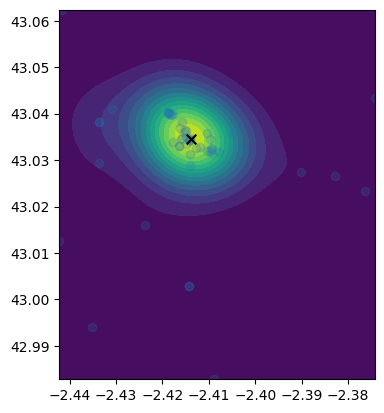

Local maxima for cluster:  14
(array([  1,  22,  39,  56,  81,  97, 112, 149]), array([ 73,  16,  60,   1, 129,  62, 149,   1]))
Local maxima within 10% of absolute max:
43.034610023811986 -2.413935903394556

Point density function for cluster:  15


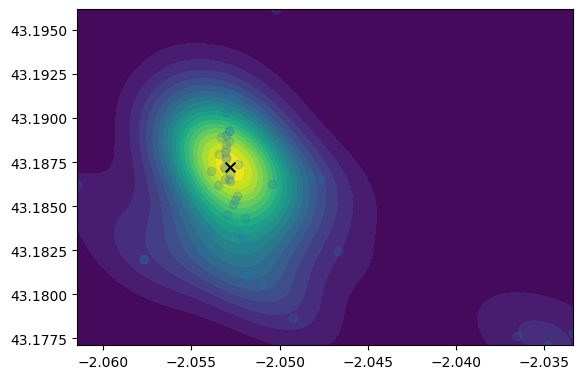

Local maxima for cluster:  15
(array([  3,  79, 148]), array([140,  46,  60]))
Local maxima within 10% of absolute max:
43.17749354746615 -2.0350615185859136
43.18722198710313 -2.0528138061490337

Point density function for cluster:  16


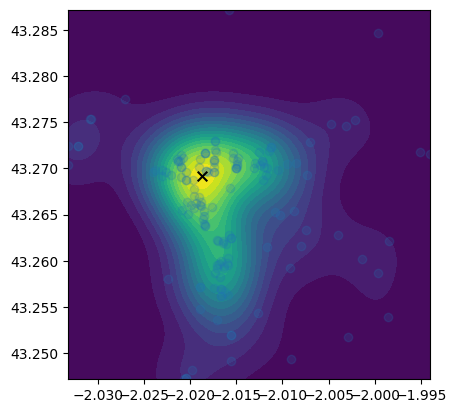

Local maxima for cluster:  16
(array([ 50,  82,  91,  96, 139, 149]), array([122,  55, 147,   5, 127,  66]))
Local maxima within 10% of absolute max:
43.26918391089853 -2.0187559988326726
43.272943267907564 -2.0319050119272024

Point density function for cluster:  17


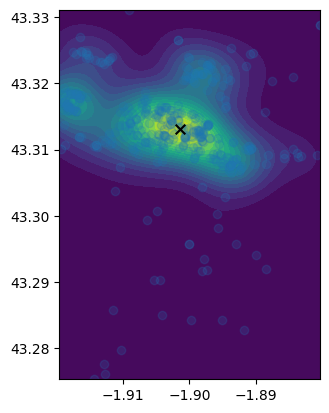

Local maxima for cluster:  17
(array([  4,  24,  50, 101, 111, 122, 143]), array([ 26,  91,  81,  69,   8,  81, 149]))
Local maxima within 10% of absolute max:
43.31315566001053 -1.9014474523729088
43.3169017861059 -1.9175606320346776
43.321022524810815 -1.8982776465378068

Point density function for cluster:  18


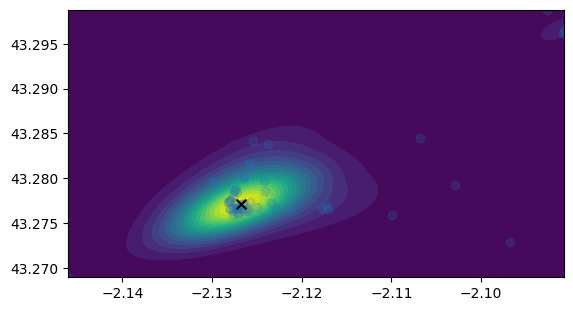

Local maxima for cluster:  18
(array([  1,  20,  40,  41,  41, 138]), array([  1, 133, 100,  52, 102, 148]))
Local maxima within 10% of absolute max:
43.27717700052014 -2.126761024168712

Point density function for cluster:  19


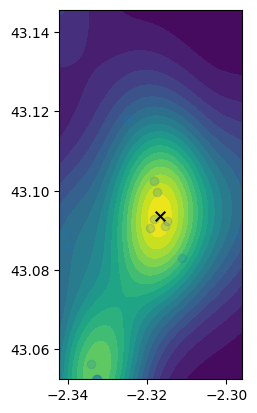

Local maxima for cluster:  19
(array([  4,  66, 148]), array([31, 82,  1]))
Local maxima within 10% of absolute max:
43.054938993446804 -2.3325325074584304
43.09373703467132 -2.316732825584902
43.145050573065035 -2.341826437972271

Point density function for cluster:  20


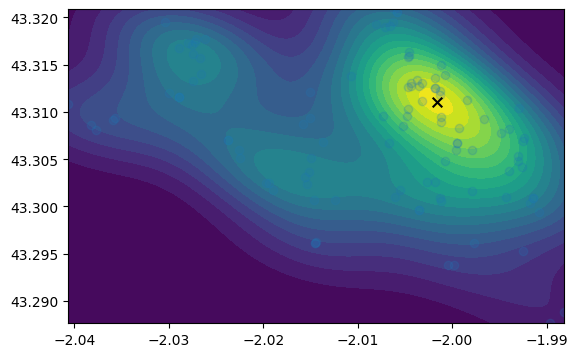

Local maxima for cluster:  20
(array([ 71, 105, 125]), array([ 69, 111,  38]))
Local maxima within 10% of absolute max:
43.303474384070874 -2.0163529393075517
43.31106328848323 -2.0015533810133257
43.315527349902275 -2.027276422810433

Point density function for cluster:  21


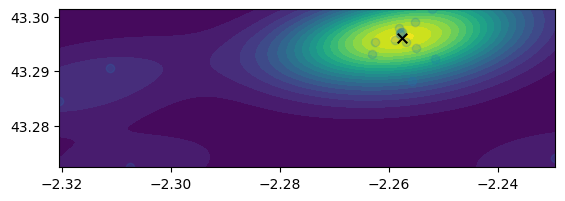

Local maxima for cluster:  21
(array([  1,   9,  78, 122]), array([ 21, 149,   8, 103]))
Local maxima within 10% of absolute max:
43.2875379031187 -2.315631349716132
43.296118309290804 -2.2575370719981422

Point density function for cluster:  22


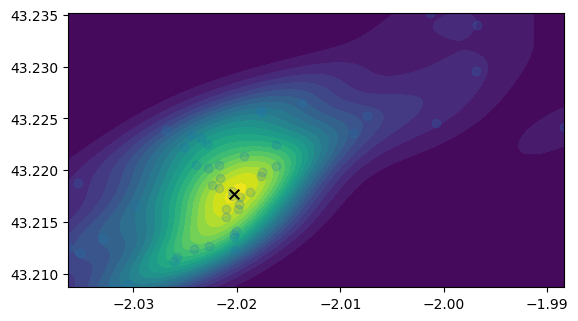

Local maxima for cluster:  22
(array([ 51,  87, 143]), array([ 50, 149, 116]))
Local maxima within 10% of absolute max:
43.21773351054093 -2.020226091997899
43.23406600129947 -1.9990007741131186


























In [24]:
#%pip install osmnx

import numpy as np
import osmnx as ox
import pandas as pd
import folium
import random
import sklearn
from sklearn.cluster import KMeans
import geopy.distance
from scipy import stats
from scipy.interpolate import interp2d

import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

from matplotlib import pyplot as plt
from google.colab import drive

#n_skip = 10
n_clusters = 23
#dist_tol = 1000 # distance tolerance for bus_stop from cluster center (in meters)

workers_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Accessibility_Map/workers_eskuzaitzeta_12_02_2024.csv", encoding='latin-1')
stops_df = df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/GTFS_files_bus_stops_12_02_2024/all_stops_12_02_2024.csv", encoding='latin-1')


def detect_local_minima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    #
    # we create the mask of the background
    background = (arr==0)
    #
    # a little technicality: we must erode the background in order to
    # successfully subtract it from local_min, otherwise a line will
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    #
    # we obtain the final mask, containing only peaks,
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)


#lat_lon = workers_df[['O_lat', 'O_long']][::n_skip] # take every n elements
workers_lat_lon = workers_df[['O_lat', 'O_long']].values.tolist()

stops_lat_lon = stops_df[['stop_lat','stop_lon']].to_numpy()


ori_lat = 43.13525255625577
ori_lon = -2.080054227169231


model = KMeans(n_clusters=n_clusters)
# fit the model
model.fit(workers_lat_lon)
# assign a cluster to each example
yhat = model.predict(workers_lat_lon)

# retrieve unique clusters
clusters = np.unique(yhat)
centers = np.array(model.cluster_centers_)

#fig,ax = plt.subplots()

XY_hdp = []
cont_cluster = 0
highDens_points = []
for cluster in clusters:
 X = []
 Y = []
 # get row indexes for samples with this cluster
 row_ix = np.where(yhat == cluster)
 # create scatter of these samples
 dist = []
 for i_cl in range(len(row_ix[0])):

     # calculate Euclidean distance of each point from cluster center
     #d = sum((p-q)**2 for p, q in zip(centers[cont_cluster], workers_lat_lon[row_ix[0][i_cl]]))**.5
     #dist.append(d)
     X.append(workers_lat_lon[row_ix[0][i_cl]][0])
     Y.append(workers_lat_lon[row_ix[0][i_cl]][1])

 #centers_ref = np.tile(centers[cont_cluster],(len(row_ix[0]),1)) # generate replicas of cluster center coords.
 #dist = [geopy.distance.geodesic((p[0],p[1]), (q[0],q[1])).km for p, q in zip(centers_ref, np.array(workers_lat_lon)[row_ix[0]])]

 # find index of the point with minimum distance from cluster center
 #index_min = np.argmin(dist)
 # assign closest point to cluster center: this tries to avoid the cluster center to fall in the middle of nowhere
 #centers[cont_cluster][0] = workers_lat_lon[row_ix[0][index_min]][0]
 #centers[cont_cluster][1] = workers_lat_lon[row_ix[0][index_min]][1]
 #highDens_points.append(xymax)

 temp_array = np.array(workers_lat_lon)[row_ix[0]]
 Lats = [temp_array[i,0] for i in range(len(temp_array))]
 Lons = [temp_array[i,1] for i in range(len(temp_array))]

 minLat = min(Lats)
 maxLat = max(Lats)
 minLon = min(Lons)
 maxLon = max(Lons)

 xy = np.vstack([Y,X])
 kernel = stats.gaussian_kde(xy)
 x,y = np.mgrid[minLat:maxLat:150j, minLon:maxLon:150j]  # 100 x 100 grid for plotting
 z = kernel.pdf(np.array([y.ravel(),x.ravel()])).reshape(x.shape)
 indmax = np.unravel_index(np.argmax(z, axis=None), z.shape)  # returns a tuple
 highestDP = (x[indmax],y[indmax])
 highDens_points.append(highestDP)

 cont_cluster+=1

 print('Point density function for cluster: ', str(cluster))
 fig,ax = plt.subplots()
 ax.contourf(y, x, z, levels=20)
 ax.axis('scaled')
 plt.scatter(Y,X, marker = 'o', alpha=0.2)
 plt.scatter(highestDP[1], highestDP[0], s=48, marker="x", color='black')
 plt.savefig('/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Point_density_cluster_'+str(cluster)+'.png')
 plt.show()

 # find local maxima
 local_minima_locations = detect_local_minima(-z)
 print('Local maxima for cluster: ', cluster)
 print(local_minima_locations)
 maxs = z[local_minima_locations]
 ind_maxs = [i for i in range(len(maxs)) if maxs[i]/max(maxs)>0.1]
 #for i_max in range(len(local_minima_locations[0])):
 print('Local maxima within 10% of absolute max:')
 for i_max in range(len(ind_maxs)):
     i_tmp = ind_maxs[i_max]
     x_coord = x.T.ravel()[local_minima_locations[0][i_tmp]]
     y_coord = y.ravel()[local_minima_locations[1][i_tmp]]
     print(x_coord, y_coord)
 print()
# plot centers
#centers = np.array(model.cluster_centers_)
#plt.scatter(centers[:,1], centers[:,0], marker="x", color='black')
#plt.show()


"""
tags = {'highway':'bus_stop',
        'bus':'yes',
        'unsigned':'yes',
        'public_transport':['stop_position','platform']}
"""
"""
tags = {'highway':'bus_stop',
        'bus':'yes'}
"""

bus_stops = []
center_ind = []
for i in range(len(centers)):
    #lat = centers[i][0]
    #lon = centers[i][1]
    lat = highDens_points[i][0]
    lon = highDens_points[i][1]

    try:
       """
       gdf = ox.features.features_from_point((lat, lon), dist = dist_tol, tags=tags)
       print('Closest stop for cluster ',i,':')
       temp0 = gdf[['geometry']].values[0][0]
       print(temp0.x, temp0.y)
       bus_stops.append((temp0.y, temp0.x))
       """

       # find closest bus stop
       ref = np.array([lat,lon])
       ref = np.tile(ref,(len(stops_lat_lon),1)) # generate replicas of ref point
       #d = [sum((p-q)**2)**0.5 for p, q in zip(ref, stops_lat_lon)] # calculate distance of each bus stop to ref point
       d = [geopy.distance.geodesic((p[0],p[1]), (q[0],q[1])).km for p, q in zip(ref, stops_lat_lon)] # calculate distance of each bus stop to ref point

       ind_min = d.index(min(d)) # find index of closest bus stop
       x = stops_lat_lon[ind_min][0]
       y = stops_lat_lon[ind_min][1]
       bus_stops.append((x, y))

       center_ind.append(i)

    except:
       print('WARNING: stops not found for cluster ',i)
       #print(centers[i])
       print(highDens_points[i])
    print()

map = folium.Map(location=[ori_lat, ori_lon], zoom_start=8)
for i in range(len(bus_stops)):
    #lat = workers_lat_lon[i][0]
    #lon = workers_lat_lon[i][1]
    latb = bus_stops[i][0]
    lonb = bus_stops[i][1]
    latc = centers[center_ind[i]][0]
    lonc = centers[center_ind[i]][1]
    latd = highDens_points[center_ind[i]][0]
    lond = highDens_points[center_ind[i]][1]
    cluster_size = len(np.where(yhat == i)[0])
    folium.Marker((latb,lonb), popup='Found bus stop position for cluster '+ str(i)).add_to(map)
    folium.Marker((latc,lonc), popup='Centroid of cluster '+ str(i) +'. Size = {}'.format(cluster_size), icon=folium.Icon(color='red')).add_to(map)
    folium.Marker((latd,lond), popup='Highest density point for cluster '+ str(i), icon=folium.Icon(color='green')).add_to(map)


"""
for i in range(len(workers_lat_lon)):
    lat = workers_lat_lon[i][0]
    lon = workers_lat_lon[i][1]
    folium.Marker((lat,lon), icon=folium.Icon(color='orange')).add_to(map)
"""

map
